# Predict NO3-N over the stream network

In [40]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
import geopandas as gpd
#from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib.gridspec import GridSpec
from matplotlib import cm
#from matplotlib.ticker import FuncFormatter, FixedLocator
from matplotlib.colors import BoundaryNorm
import rioxarray
import xarray as xr
import rasterio
import dask
from shapely.geometry import mapping

In [2]:
# Setting the display options for dataframes
pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = 1000

In [3]:
# function to load environmental variables to the notebook. These datasets were processed and saved in other notebooks. 

def import_features(feature):
    clim_var = None
    with open(feature, 'rb') as file:
        # Deserialize and retrieve the variable from the file
        clim_var = pickle.load(file)
    return clim_var

In [4]:
# Add the data for all 12 months in dictionaries with the month name as key

months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
dataframes = {}
X_train_months = {}
y_train_months = {}
X_test_months = {}
y_test_months = {}
best_params_months = {}
scaler_months = {}


for i,month in enumerate(months):
    with open(f"final_df_{month}_new", 'rb') as file:
        final_df_month_new = pickle.load(file)
    dataframes[month] = final_df_month_new
    scaler = StandardScaler()
    scaler.fit(final_df_month_new.iloc[:, 7:])
    scaler_months[month] = scaler
    
    with open(f"X_train_nss_{month}", 'rb') as file:
        X_train_month = pickle.load(file)
    X_train_months[month] = X_train_month	

    with open(f"y_train_nss_{month}", 'rb') as file:
        y_train_month = pickle.load(file)
    y_train_months[month] = y_train_month	


    with open(f"X_test_nss_{month}", 'rb') as file:
        X_test_month = pickle.load(file)
    X_test_months[month] = X_test_month	

    with open(f"y_test_nss_{month}", 'rb') as file:
        y_test_month = pickle.load(file)
    y_test_months[month] = y_test_month



    
    with open(f"study_opt_nss_bc_best_params_{month}", 'rb') as file:
        study_opt_nss_bc_best_params = pickle.load(file)
    best_params_months[month] = study_opt_nss_bc_best_params	    

In [5]:
with open("lambda_boxcox", 'rb') as file:
    lambda_boxcox = pickle.load(file)

# Load the shapefile
shapefile_path = r"z\study_project\geoBoundaries-DEU-ADM1-all\bavaria_outline.shp"
bavaria_polygon = gpd.read_file(shapefile_path)
bavaria_polygon = bavaria_polygon.to_crs('EPSG:4326')

In [6]:
dataframes['jul']

NO3-N [mg/l]  NO3-N [mg/l] BC  \
0        4.821333         2.188384   
1        2.471000         1.028438   
2        3.766667         1.714114   
3        2.734500         1.145806   
4        4.819500         2.106403   
5        6.328000         2.726419   
6        6.629333         2.821920   
7        2.881500         1.301034   
8        2.591333         1.139601   
9        1.039571         0.037623   
10       0.682400        -0.357717   
11       3.237500         1.476225   
12       1.001667        -0.005439   
13       1.779750         0.580340   
14       1.777667         0.640398   
15       4.407000         2.020808   
16       3.415111         1.575748   
17       1.508250         0.412380   
18       1.536667         0.466496   
19       0.596333        -0.474446   
20       7.420333         3.054307   
21       3.486857         1.607538   
22       4.616544         2.083653   
23       3.537000         1.506469   
24       3.860447         1.772242   
25       1.555353         0.468526   
26       0.565000        -0.515141   
27       2.697138         1.194713   
28       3.584034         1.641522   
29       0.520000        -0.575478   
30       3.785500         1.737444   
31       5.198000         2.329296   
32       4.520000         2.063109   
33       8.211333         3.301091   
34       3.150400         1.249247   
35       0.542000        -0.543303   
36       2.561333         1.136420   
37       2.702744         1.214877   
38       0.416059        -0.742259   
39       1.178270         0.151467   
40       4.444667         2.031921   
41       1.232316         0.205560   
42       0.979167        -0.024301   
43       4.670667         2.103293   
44       1.864077         0.699466   
45       1.152500         0.144944   
46       0.729268        -0.306586   
47       3.073500         1.388246   
48       2.655500         1.187692   
49       0.972000        -0.215174   
50       4.124500         1.866338   
51       1.998429         0.786795   
52       2.636667         1.178886   
53       0.881333        -0.162071   
54       4.407000         1.988155   
55       0.490000        -0.621116   
56       1.182667         0.153915   
57       1.172900        -0.006375   
58       4.407000         2.006335   
59       3.073667         1.225940   
60       4.520000         2.066382   
61       2.410667         1.053562   
62       3.621947         1.679853   
63       4.407000         2.020808   
64       3.768649         1.720178   
65       5.819500         2.552450   
66       4.143333         1.892300   
67       1.993474         0.787719   
68       3.164000         1.451925   
69       0.966000        -0.035741   
70       5.001478         2.246021   
71       0.949700        -0.059476   
72       1.785500         0.650753   
73       0.935400        -0.067334   
74       3.069000         1.371356   
75       3.465333         1.600683   
76       1.017000        -0.005816   
77       4.859000         2.198904   
78       2.787333         1.266206   
79       1.898333         0.721668   
80       2.360324         1.007700   
81       2.684878         1.192162   
82       2.147000         0.839526   
83       2.132000         0.837188   
84       4.143333         1.867947   
85       2.034000         0.591239   
86       0.538000        -0.556538   
87       0.753333        -0.280632   
88       2.380667         1.028540   
89       3.390000         1.568994   
90       6.177333         2.677747   
91       2.418250         1.056049   
92       3.540667         1.644504   
93       2.542500         1.124599   
94       1.115000         0.094030   
95       4.248800         1.951996   
96       2.486000         1.096626   
97       2.180500         0.914332   
98       1.536667         0.401666   
99       3.917333         1.792363   
100      0.514844        -0.585379   
101      7.458000         3.077887   
102      4.785550         2.140339   
103      0.660842        -0.386065   
104      4.6047

In [7]:
# Implement the import_features function to load environmental variables

df_filtered_slope = import_features("df_filtered_slope")
df_filtered_elev_avg = import_features("df_filtered_elev_avg")
df_filtered_landcover = import_features("df_filtered_landcover")
df_filtered_hydroclim = import_features("df_filtered_hydroclim")
df_filtered_soil_avg = import_features("df_filtered_soil_avg")
df_filtered_tmin_avg = import_features("df_filtered_tmin_avg")
df_filtered_tmax_avg = import_features("df_filtered_tmax_avg")
df_filtered_prec_us_sum = import_features("df_filtered_prec_us_sum")

In [8]:
df_filtered_slope

variable   index        lat        lon       3
0           1902  47.295833  10.229167  1423.0
1           2487  47.304167  10.237500  1436.0
2           2488  47.304167  10.245833  1463.0
3           3073  47.312500  10.254167  1493.0
4           3074  47.312500  10.262500  1532.0
...          ...        ...        ...     ...
16445     228480  50.529167  10.112500   350.0
16446     228481  50.529167  10.120833   370.0
16447     228482  50.529167  10.129167   373.0
16448     228484  50.529167  10.145833   366.0
16449     229067  50.537500  10.137500   372.0

[16450 rows x 4 columns]

In [9]:
df_filtered_elev_avg

variable   index        lat        lon       3
0           1902  47.295833  10.229167  1798.0
1           2487  47.304167  10.237500  1781.0
2           2488  47.304167  10.245833  1752.0
3           3073  47.312500  10.254167  1741.0
4           3074  47.312500  10.262500  1761.0
...          ...        ...        ...     ...
16445     228480  50.529167  10.112500   716.0
16446     228481  50.529167  10.120833   699.0
16447     228482  50.529167  10.129167   676.0
16448     228484  50.529167  10.145833   640.0
16449     229067  50.537500  10.137500   656.0

[16450 rows x 4 columns]

In [10]:
df_filtered_landcover

variable   index        lat        lon     0    1     2     3    4     5  \
0           1902  47.295833  10.229167  29.0  0.0   6.0   7.0  3.0  25.0   
1           2487  47.304167  10.237500  28.0  0.0   6.0   6.0  3.0  25.0   
2           2488  47.304167  10.245833  28.0  0.0   8.0   8.0  4.0  23.0   
3           3073  47.312500  10.254167  27.0  0.0   7.0   9.0  4.0  24.0   
4           3074  47.312500  10.262500  25.0  0.0   7.0  10.0  5.0  23.0   
...          ...        ...        ...   ...  ...   ...   ...  ...   ...   
16445     228480  50.529167  10.112500   0.0  0.0   7.0  10.0  0.0  10.0   
16446     228481  50.529167  10.120833   0.0  0.0   7.0   9.0  0.0  10.0   
16447     228482  50.529167  10.129167   0.0  0.0   6.0   8.0  0.0   9.0   
16448     228484  50.529167  10.145833   0.0  0.0  10.0  17.0  0.0   5.0   
16449     229067  50.537500  10.137500   0.0  0.0  11.0  18.0  0.0   6.0   

variable     6    7    8    9    10   11  
0         20.0  0.0  0.0  0.0   8.0  2.0  
1         21.0  0.0  0.0  0.0   8.0  2.0  
2         20.0  0.0  0.0  0.0   7.0  2.0  
3         21.0  0.0  0.0  0.0   7.0  2.0  
4         18.0  0.0  0.0  0.0  10.0  2.0  
...        ...  ...  ...  ...   ...  ...  
16445     66.0  0.0  0.0  0.0   7.0  0.0  
16446     66.0  0.0  0.0  0.0   9.0  0.0  
16447     66.0  0.0  0.0  0.0  11.0  0.0  
16448     55.0  0.0  0.0  0.0  12.0  0.0  
16449     55.0  0.0  0.0  0.0  10.0  0.0  

[16450 rows x 15 columns]

In [11]:
df_filtered_tmin_avg

variable   index        lat        lon     0     1     2     3     4     5  \
0           1902  47.295833  10.229167 -79.0 -72.0 -40.0  -3.0  36.0  69.0   
1           2487  47.304167  10.237500 -81.0 -74.0 -43.0  -7.0  33.0  66.0   
2           2488  47.304167  10.245833 -80.0 -73.0 -42.0  -6.0  33.0  66.0   
3           3073  47.312500  10.254167 -80.0 -74.0 -43.0  -7.0  33.0  65.0   
4           3074  47.312500  10.262500 -80.0 -73.0 -42.0  -6.0  34.0  66.0   
...          ...        ...        ...   ...   ...   ...   ...   ...   ...   
16445     228480  50.529167  10.112500 -48.0 -43.0 -18.0  10.0  51.0  84.0   
16446     228481  50.529167  10.120833 -47.0 -43.0 -18.0  10.0  52.0  85.0   
16447     228482  50.529167  10.129167 -47.0 -42.0 -17.0  10.0  52.0  85.0   
16448     228484  50.529167  10.145833 -46.0 -41.0 -16.0  11.0  53.0  86.0   
16449     229067  50.537500  10.137500 -47.0 -42.0 -17.0  10.0  52.0  85.0   

variable      6      7     8     9    10    11  
0          88.0   85.0  62.0  21.0 -24.0 -62.0  
1          85.0   82.0  60.0  19.0 -26.0 -64.0  
2          86.0   83.0  60.0  20.0 -25.0 -64.0  
3          85.0   82.0  59.0  19.0 -26.0 -64.0  
4          86.0   83.0  60.0  20.0 -25.0 -64.0  
...         ...    ...   ...   ...   ...   ...  
16445     102.0   99.0  67.0  32.0   0.0 -27.0  
16446     102.0  100.0  68.0  32.0   0.0 -27.0  
16447     102.0  100.0  68.0  32.0   0.0 -26.0  
16448     103.0  101.0  69.0  33.0   1.0 -25.0  
16449     103.0  100.0  68.0  32.0   0.0 -26.0  

[16450 rows x 15 columns]

In [12]:
### MERGE ALL THE STATIC FEATURE DATA REQUIRED TO MAKE PREDICTIONS IN A SINGLE DATAFRAME

# Merge the dataframe one by one using the coorindates as the common data. Drop some columns to improve formatting. 
# Suffixes option is specified while merging because all environmental variables dataframes have similar naming convention for columns
df1 = df_filtered_slope.drop(columns='index')
df2 = pd.merge(df1, df_filtered_elev_avg, on=['lon', 'lat'], how='left')
df2 = df2.drop(columns='index')
df3 = pd.merge(df2, df_filtered_landcover, on=['lon', 'lat'], how='left')
df3 = df3.drop(columns='index')
df4 = pd.merge(df3, df_filtered_hydroclim, on=['lon', 'lat'], how='left',suffixes=(None, 'hydroclim'))
df4 = df4.drop(columns='index')
df5 = pd.merge(df4, df_filtered_soil_avg, on=['lon', 'lat'], how='left',suffixes=(None, 'soil_avg'))
df5 = df5.drop(columns='index')


In [13]:
df5

variable        lat        lon     3_x     3_y     0    1     2     3    4  \
0         47.295833  10.229167  1423.0  1798.0  29.0  0.0   6.0   7.0  3.0   
1         47.304167  10.237500  1436.0  1781.0  28.0  0.0   6.0   6.0  3.0   
2         47.304167  10.245833  1463.0  1752.0  28.0  0.0   8.0   8.0  4.0   
3         47.312500  10.254167  1493.0  1741.0  27.0  0.0   7.0   9.0  4.0   
4         47.312500  10.262500  1532.0  1761.0  25.0  0.0   7.0  10.0  5.0   
...             ...        ...     ...     ...   ...  ...   ...   ...  ...   
16445     50.529167  10.112500   350.0   716.0   0.0  0.0   7.0  10.0  0.0   
16446     50.529167  10.120833   370.0   699.0   0.0  0.0   7.0   9.0  0.0   
16447     50.529167  10.129167   373.0   676.0   0.0  0.0   6.0   8.0  0.0   
16448     50.529167  10.145833   366.0   640.0   0.0  0.0  10.0  17.0  0.0   
16449     50.537500  10.137500   372.0   656.0   0.0  0.0  11.0  18.0  0.0   

variable     5     6    7    8    9    10   11  0hydroclim  1hydroclim  \
0         25.0  20.0  0.0  0.0  0.0   8.0  2.0        51.0        89.0   
1         25.0  21.0  0.0  0.0  0.0   8.0  2.0        47.0        87.0   
2         23.0  20.0  0.0  0.0  0.0   7.0  2.0        48.0        87.0   
3         24.0  21.0  0.0  0.0  0.0   7.0  2.0        47.0        87.0   
4         23.0  18.0  0.0  0.0  0.0  10.0  2.0        48.0        87.0   
...        ...   ...  ...  ...  ...   ...  ...         ...         ...   
16445     10.0  66.0  0.0  0.0  0.0   7.0  0.0        71.0        91.0   
16446     10.0  66.0  0.0  0.0  0.0   9.0  0.0        71.0        91.0   
16447      9.0  66.0  0.0  0.0  0.0  11.0  0.0        71.0        91.0   
16448      5.0  55.0  0.0  0.0  0.0  12.0  0.0        72.0        91.0   
16449      6.0  55.0  0.0  0.0  0.0  10.0  0.0        72.0        91.0   

variable  2hydroclim  3hydroclim  4hydroclim  5hydroclim  6hydroclim  \
0               33.0      6325.0       189.0       -79.0       268.0   
1               32.0      6276.0       184.0       -81.0       265.0   
2               33.0      6255.0       184.0       -80.0       264.0   
3               33.0      6261.0       183.0       -80.0       263.0   
4               33.0      6253.0       184.0       -80.0       264.0   
...              ...         ...         ...         ...         ...   
16445           34.0      6353.0       217.0       -48.0       265.0   
16446           34.0      6353.0       217.0       -47.0       264.0   
16447           34.0      6342.0       217.0       -47.0       264.0   
16448           34.0      6348.0       218.0       -46.0       264.0   
16449           34.0      6353.0       217.0       -47.0       264.0   

variable  7hydroclim  8hydroclim  9hydroclim  10hydroclim  11hydroclim  \
0              130.0       -21.0       130.0        -31.0      33503.0   
1              126.0       -24.0       126.0        -34.0      36881.0   
2              126.0       -23.0       126.0        -33.0      42307.0   
3              125.0       -24.0       125.0        -34.0      45645.0   
4              126.0       -23.0       126.0        -33.0      59137.0   
...              ...         ...         ...          ...          ...   
16445          153.0        28.0       153.0        -10.0      27592.0   
16446          153.0        28.0       153.0         -9.0      29871.0   
16447          153.0        28.0       153.0         -9.0      32851.0   
16448          154.0        29.0       154.0         -8.0      59276.0   
16449          154.0        28.0       154.0         -9.0      54888.0   

variable      12      13    14       15       16       17       18  0soil_avg  \
0         4184.0  1950.0  27.0  11917.0   6160.0  11917.0   6160.0       98.0   
1         4614.0  2140.0  27.0  13139.0   6759.0  13139.0   6759.0       97.0   
2         5308.0  2439.0  28.0  15118.0   7700.0  15118.0   7700.0      100.0   
3         5734.0  2625.0  28.0  16331.0   8287.0  16331.0   8287.0       98.0   
4         7399.

In [14]:
# Rename the columns

new_names = ['slope_avg',
    'elev_avg',
    'lc_avg_01',
    'lc_avg_02',
    'lc_avg_03',
    'lc_avg_04',
    'lc_avg_05',
    'lc_avg_06',
    'lc_avg_07',
    'lc_avg_08',
    'lc_avg_09',
    'lc_avg_10',
    'lc_avg_11',
    'lc_avg_12',
    'hydro_avg_01',
    'hydro_avg_02',
    'hydro_avg_03',
    'hydro_avg_04',
    'hydro_avg_05',
    'hydro_avg_06',
    'hydro_avg_07',
    'hydro_avg_08',
    'hydro_avg_09',
    'hydro_avg_10',
    'hydro_avg_11',
    'hydro_avg_12',
    'hydro_avg_13',
    'hydro_avg_14',
    'hydro_avg_15',
    'hydro_avg_16',
    'hydro_avg_17',
    'hydro_avg_18',
    'hydro_avg_19',
    'soil_avg_01',
    'soil_avg_02',
    'soil_avg_03',
    'soil_avg_04',
    'soil_avg_05',
    'soil_avg_06',
    'soil_avg_07',
    'soil_avg_08',
    'soil_avg_09',
    'soil_avg_10']
# Create a dictionary mapping old column names to new ones
rename_dict = {df5.columns[i]: new_names[i - 2] for i in range(2, 45)}

# Rename the columns using the names defined above
df5.rename(columns=rename_dict, inplace=True)

In [15]:
df5

variable        lat        lon  slope_avg  elev_avg  lc_avg_01  lc_avg_02  \
0         47.295833  10.229167     1423.0    1798.0       29.0        0.0   
1         47.304167  10.237500     1436.0    1781.0       28.0        0.0   
2         47.304167  10.245833     1463.0    1752.0       28.0        0.0   
3         47.312500  10.254167     1493.0    1741.0       27.0        0.0   
4         47.312500  10.262500     1532.0    1761.0       25.0        0.0   
...             ...        ...        ...       ...        ...        ...   
16445     50.529167  10.112500      350.0     716.0        0.0        0.0   
16446     50.529167  10.120833      370.0     699.0        0.0        0.0   
16447     50.529167  10.129167      373.0     676.0        0.0        0.0   
16448     50.529167  10.145833      366.0     640.0        0.0        0.0   
16449     50.537500  10.137500      372.0     656.0        0.0        0.0   

variable  lc_avg_03  lc_avg_04  lc_avg_05  lc_avg_06  lc_avg_07  lc_avg_08  \
0               6.0        7.0        3.0       25.0       20.0        0.0   
1               6.0        6.0        3.0       25.0       21.0        0.0   
2               8.0        8.0        4.0       23.0       20.0        0.0   
3               7.0        9.0        4.0       24.0       21.0        0.0   
4               7.0       10.0        5.0       23.0       18.0        0.0   
...             ...        ...        ...        ...        ...        ...   
16445           7.0       10.0        0.0       10.0       66.0        0.0   
16446           7.0        9.0        0.0       10.0       66.0        0.0   
16447           6.0        8.0        0.0        9.0       66.0        0.0   
16448          10.0       17.0        0.0        5.0       55.0        0.0   
16449          11.0       18.0        0.0        6.0       55.0        0.0   

variable  lc_avg_09  lc_avg_10  lc_avg_11  lc_avg_12  hydro_avg_01  \
0               0.0        0.0        8.0        2.0          51.0   
1               0.0        0.0        8.0        2.0          47.0   
2               0.0        0.0        7.0        2.0          48.0   
3               0.0        0.0        7.0        2.0          47.0   
4               0.0        0.0       10.0        2.0          48.0   
...             ...        ...        ...        ...           ...   
16445           0.0        0.0        7.0        0.0          71.0   
16446           0.0        0.0        9.0        0.0          71.0   
16447           0.0        0.0       11.0        0.0          71.0   
16448           0.0        0.0       12.0        0.0          72.0   
16449           0.0        0.0       10.0        0.0          72.0   

variable  hydro_avg_02  hydro_avg_03  hydro_avg_04  hydro_avg_05  \
0                 89.0          33.0        6325.0         189.0   
1                 87.0          32.0        6276.0         184.0   
2                 87.0          33.0        6255.0         184.0   
3                 87.0          33.0        6261.0         183.0   
4                 87.0          33.0        6253.0         184.0   
...                ...           ...           ...           ...   
16445             91.0          34.0        6353.0         217.0   
16446             91.0          34.0        6353.0         217.0   
16447             91.0          34.0        6342.0         217.0   
16448             91.0          34.0        6348.0         218.0   
16449             91.0          34.0        6353.0         217.0   

variable  hydro_avg_06  hydro_avg_07  hydro_avg_08  hydro_avg_09  \
0                -79.0         268.0         130.0         -21.0   
1                -81.0         265.0         126.0         -24.0   
2                -80.0         264.0         126.0         -23.0   
3                -80.0         263.0         125.0         -24.0   
4                -80.0         264.0         126.0         -23.0   
...                ...           ...           ...           ...   
1644

In [21]:
# Add the time dependent features to df5 and save a new dataframe for every month 

months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
pred_dfs = {}
pred_dfs_scaled = {}

for i,month in enumerate(months):
    df_month = df5.copy()
    df_month[f"tmin_avg_{i+1}"] = df_filtered_tmin_avg.iloc[:,i+3]
    df_month[f"tmax_avg_{i+1}"] = df_filtered_tmax_avg.iloc[:,i+3]
    df_month[f"prec_sum_{i+1}"] = df_filtered_prec_us_sum.iloc[:,i+3]
    df_month.insert(2, "month", i+1)
    
    scaler = scaler_months[month]
    scaled_features = scaler.transform(df_month.iloc[:, 3:])
    scaled_df = pd.DataFrame(scaled_features, index=df_month.index, columns=df_month.columns[3:])
    scaled_df = scaled_df.astype('float32')  # Explicitly cast to float32 if needed because the data type might not match
    df_month.iloc[:, 3:] = scaled_df
    pred_dfs_scaled[month] = df_month

In [22]:
pred_dfs_scaled["aug"]

variable        lat        lon  month  slope_avg  elev_avg  lc_avg_01  \
0         47.295833  10.229167      8   4.328257  4.508873   1.570108   
1         47.304167  10.237500      8   4.376041  4.445128   1.484605   
2         47.304167  10.245833      8   4.475286  4.336388   1.484605   
3         47.312500  10.254167      8   4.585558  4.295142   1.399101   
4         47.312500  10.262500      8   4.728911  4.370135   1.228094   
...             ...        ...    ...        ...       ...        ...   
16445     50.529167  10.112500      8   0.384199  0.451739  -0.909494   
16446     50.529167  10.120833      8   0.457714  0.387995  -0.909494   
16447     50.529167  10.129167      8   0.468741  0.301753  -0.909494   
16448     50.529167  10.145833      8   0.443011  0.166765  -0.909494   
16449     50.537500  10.137500      8   0.465066  0.226759  -0.909494   

variable  lc_avg_02  lc_avg_03  lc_avg_04  lc_avg_05  lc_avg_06  lc_avg_07  \
0               0.0  -0.603395  -0.986438   5.075329   6.356575  -1.358679   
1               0.0  -0.603395  -1.084347   5.075329   6.356575  -1.310092   
2               0.0  -0.262451  -0.888529   6.862571   5.775329  -1.358679   
3               0.0  -0.432923  -0.790620   6.862571   6.065952  -1.310092   
4               0.0  -0.432923  -0.692711   8.649812   5.775329  -1.455855   
...             ...        ...        ...        ...        ...        ...   
16445           0.0  -0.432923  -0.692711  -0.286394   1.997225   0.876351   
16446           0.0  -0.432923  -0.790620  -0.286394   1.997225   0.876351   
16447           0.0  -0.603395  -0.888529  -0.286394   1.706602   0.876351   
16448           0.0   0.078493  -0.007348  -0.286394   0.544108   0.341887   
16449           0.0   0.248965   0.090561  -0.286394   0.834732   0.341887   

variable  lc_avg_08  lc_avg_09  lc_avg_10  lc_avg_11  lc_avg_12  hydro_avg_01  \
0         -0.090443  -0.474262   -0.18597  -0.161036   1.082593     -3.798467   
1         -0.090443  -0.474262   -0.18597  -0.161036   1.082593     -4.352381   
2         -0.090443  -0.474262   -0.18597  -0.406068   1.082593     -4.213902   
3         -0.090443  -0.474262   -0.18597  -0.406068   1.082593     -4.352381   
4         -0.090443  -0.474262   -0.18597   0.329029   1.082593     -4.213902   
...             ...        ...        ...        ...        ...           ...   
16445     -0.090443  -0.474262   -0.18597  -0.406068  -0.348287     -1.028898   
16446     -0.090443  -0.474262   -0.18597   0.083997  -0.348287     -1.028898   
16447     -0.090443  -0.474262   -0.18597   0.574062  -0.348287     -1.028898   
16448     -0.090443  -0.474262   -0.18597   0.819094  -0.348287     -0.890419   
16449     -0.090443  -0.474262   -0.18597   0.329029  -0.348287     -0.890419   

variable  hydro_avg_02  hydro_avg_03  hydro_avg_04  hydro_avg_05  \
0             0.374271      1.543603     -2.202388     -4.127173   
1            -0.140417      0.442306     -2.461487     -4.687263   
2            -0.140417      1.543603     -2.572529     -4.687263   
3            -0.140417      1.543603     -2.540803     -4.799282   
4            -0.140417      1.543603     -2.583105     -4.687263   
...                ...           ...           ...           ...   
16445         0.888959      2.644901     -2.054332     -0.990667   
16446         0.888959      2.644901     -2.054332     -0.990667   
16447         0.888959      2.644901     -2.112497     -0.990667   
16448         0.888959      2.644901     -2.080770     -0.878649   
16449         0.888959      2.644901     -2.054332     -0.990667   

variable  hydro_avg_06  hydro_avg_07  hydro_avg_08  hydro_avg_09  \
0            -2.822934     -0.710231     -4.254687     -2.210477   
1            -3.007266     -1.053062     -4.762234     -2.398617   
2            -2.915100     -1.167339     -4.762234     -2.335903   
3            -2.915100     -1.281615     -4.889120     -2.398617   
4            -2.915100     -1.167339     -4.762234     -

In [23]:
# Fitting the best model

best_models = {}

for i,month in enumerate(months):
    
    best_n_estimators = best_params_months[month]['n_estimators']
    best_max_depth = best_params_months[month]['max_depth']
    best_min_samples_split = best_params_months[month]['min_samples_split']
    best_min_samples_leaf = best_params_months[month]['min_samples_leaf']
    
    best_model_month = RandomForestRegressor(n_estimators = best_n_estimators, max_depth = best_max_depth , 
                                                  min_samples_split= best_min_samples_split, 
                                                  min_samples_leaf=best_min_samples_leaf, random_state=42, n_jobs=3)
    
    best_model_month.fit(X_train_months[month], y_train_months[month])
    
    best_models[month] = best_model_month

    y_pred_check = best_model_month.predict(X_test_months[month])
    r2 = r2_score(y_test_months[month], y_pred_check)
    print(month, ' ,R2 = ', r2)

jan  ,R2 =  0.6453086598665858
feb  ,R2 =  0.5906513232415356
mar  ,R2 =  0.6007152123111279
apr  ,R2 =  0.6559327630034304
may  ,R2 =  0.5144278888881411
jun  ,R2 =  0.5808383354139224
jul  ,R2 =  0.4943774790457538
aug  ,R2 =  0.4875001259094296
sep  ,R2 =  0.5933356969330963
oct  ,R2 =  0.5079963598199626
nov  ,R2 =  0.4206583795435438
dec  ,R2 =  0.6119189650423125


In [24]:
# # Make predictions and add stations measurements to predictions

# dfs_to_save = {}
# prediction_dataframes = pred_dfs_scaled.copy()
# for i,month in enumerate(months):
#     lengths = 0
#     X_predict = pred_dfs_scaled[month].iloc[:,3:]
#     X_predict_copy = (pred_dfs_scaled[month].iloc[:,3:]).values
#     y_predict = best_models[month].predict(X_predict_copy)
#     pred_dfs_scaled[month]["y_pred_bc"] = y_predict
#     pred_dfs_scaled[month]["y_pred_og"] = inv_boxcox(y_predict, lambda_boxcox)
#     prediction_dataframes[month]["y_pred_bc"] = y_predict
#     prediction_dataframes[month]["y_pred_og"] = inv_boxcox(y_predict, lambda_boxcox)

    
#     for index, row in dataframes[month].iterrows():
#         lon = row['lon']
#         lat = row['lat']
#         mask = (
#         (pred_dfs_scaled[month]['lon'] == lon) & 
#         (pred_dfs_scaled[month]['lat'] == lat)
#         )        
#         pred_dfs_scaled[month][mask]['y_pred_bc'] = row['NO3-N [mg/l] BC']
#         pred_dfs_scaled[month][mask]['y_pred_og'] = row['NO3-N [mg/l]']
#         lengths = lengths + pred_dfs_scaled[month][mask].shape[0]
#     print(month, ' :', lengths)
#     predictions_gdf = gpd.GeoDataFrame( pred_dfs_scaled[month].loc[:,'y_pred_og'], geometry=gpd.points_from_xy(pred_dfs_scaled[month].lon, pred_dfs_scaled[month].lat),crs='EPSG:4326')
#     predictions_gdf =  predictions_gdf.rename(columns={"y_pred_og": "NO3-N [mg/l]" })
#     dfs_to_save[month] = predictions_gdf

# #     month_slice.to_file(f"predicted_NO3_conc_{months[i-1]}.shp")

In [25]:
# Make predictions and add stations measurements to predictions

dfs_to_save = {}
prediction_dataframes = {}
for i,month in enumerate(months):
    #lengths = 0
    prediction_dataframes[month] =  pred_dfs_scaled[month].copy()
    X_predict = pred_dfs_scaled[month].iloc[:,3:]
    X_predict_copy = (pred_dfs_scaled[month].iloc[:,3:]).values
    y_predict = best_models[month].predict(X_predict_copy)
    pred_dfs_scaled[month]["y_pred_bc"] = y_predict
    pred_dfs_scaled[month]["y_pred_og"] = inv_boxcox(y_predict, lambda_boxcox)
    prediction_dataframes[month]["y_pred_bc"] = y_predict
    prediction_dataframes[month]["y_pred_og"] = inv_boxcox(y_predict, lambda_boxcox)

    
    # for index, row in dataframes[month].iterrows():
    #     lon = row['lon']
    #     lat = row['lat']
    #     mask = (
    #     (pred_dfs_scaled[month]['lon'] == lon) & 
    #     (pred_dfs_scaled[month]['lat'] == lat)
    #     )        
    #     pred_dfs_scaled[month].loc[mask,'y_pred_bc'] = row['NO3-N [mg/l] BC']
    #     pred_dfs_scaled[month].loc[mask,'y_pred_og'] = row['NO3-N [mg/l]']
    #     lengths = lengths + pred_dfs_scaled[month][mask].shape[0]
    #print(month, ' :', lengths)
    predictions_gdf = gpd.GeoDataFrame( pred_dfs_scaled[month].loc[:,'y_pred_og'], geometry=gpd.points_from_xy(pred_dfs_scaled[month].lon, pred_dfs_scaled[month].lat),crs='EPSG:4326')
    predictions_gdf =  predictions_gdf.rename(columns={"y_pred_og": "NO3-N [mg/l]" })
    dfs_to_save[month] = predictions_gdf

#     month_slice.to_file(f"predicted_NO3_conc_{months[i-1]}.shp")

In [26]:
X_predict

variable  slope_avg  elev_avg  lc_avg_01  lc_avg_02  lc_avg_03  lc_avg_04  \
0          4.328008  4.512228   1.560969        0.0  -0.616476  -1.014696   
1          4.375829  4.448348   1.475274        0.0  -0.616476  -1.113476   
2          4.475151  4.339377   1.475274        0.0  -0.273951  -0.915917   
3          4.585507  4.298044   1.389579        0.0  -0.445213  -0.817138   
4          4.728971  4.373196   1.218190        0.0  -0.445213  -0.718359   
...             ...       ...        ...        ...        ...        ...   
16445      0.380911  0.446491  -0.924180        0.0  -0.445213  -0.718359   
16446      0.454482  0.382612  -0.924180        0.0  -0.445213  -0.817138   
16447      0.465518  0.296187  -0.924180        0.0  -0.616476  -0.915917   
16448      0.439768  0.160913  -0.924180        0.0   0.068575  -0.026903   
16449      0.461839  0.221035  -0.924180        0.0   0.239837   0.071876   

variable  lc_avg_05  lc_avg_06  lc_avg_07  lc_avg_08  lc_avg_09  lc_avg_10  \
0          5.133574   6.423195  -1.359238  -0.090536  -0.477439  -0.182399   
1          5.133574   6.423195  -1.309895  -0.090536  -0.477439  -0.182399   
2          6.938947   5.835304  -1.359238  -0.090536  -0.477439  -0.182399   
3          6.938947   6.129250  -1.309895  -0.090536  -0.477439  -0.182399   
4          8.744321   5.835304  -1.457924  -0.090536  -0.477439  -0.182399   
...             ...        ...        ...        ...        ...        ...   
16445     -0.282548   2.014007   0.910538  -0.090536  -0.477439  -0.182399   
16446     -0.282548   2.014007   0.910538  -0.090536  -0.477439  -0.182399   
16447     -0.282548   1.720061   0.910538  -0.090536  -0.477439  -0.182399   
16448     -0.282548   0.544278   0.367766  -0.090536  -0.477439  -0.182399   
16449     -0.282548   0.838224   0.367766  -0.090536  -0.477439  -0.182399   

variable  lc_avg_11  lc_avg_12  hydro_avg_01  hydro_avg_02  hydro_avg_03  \
0         -0.155501   1.087251     -3.808766      0.364596      1.545189   
1         -0.155501   1.087251     -4.365070     -0.145735      0.441803   
2         -0.399152   1.087251     -4.225994     -0.145735      1.545189   
3         -0.399152   1.087251     -4.365070     -0.145735      1.545189   
4          0.331801   1.087251     -4.225994     -0.145735      1.545189   
...             ...        ...           ...           ...           ...   
16445     -0.399152  -0.346871     -1.027242      0.874927      2.648575   
16446      0.088150  -0.346871     -1.027242      0.874927      2.648575   
16447      0.575452  -0.346871     -1.027242      0.874927      2.648575   
16448      0.819103  -0.346871     -0.888165      0.874927      2.648575   
16449      0.331801  -0.346871     -0.888165      0.874927      2.648575   

variable  hydro_avg_04  hydro_avg_05  hydro_avg_06  hydro_avg_07  \
0            -2.190832     -4.103091     -2.834814     -0.713114   
1            -2.448150     -4.660687     -3.020580     -1.054189   
2            -2.558429     -4.660687     -2.927697     -1.167880   
3            -2.526921     -4.772207     -2.927697     -1.281572   
4            -2.568932     -4.660687     -2.927697     -1.167880   
...                ...           ...           ...           ...   
16445        -2.043793     -0.980553      0.044554     -1.054189   
16446        -2.043793     -0.980553      0.137436     -1.167880   
16447        -2.101558     -0.980553      0.137436     -1.167880   
16448        -2.070050     -0.869034      0.230319     -1.167880   
16449        -2.043793     -0.980553      0.137436     -1.167880   

variable  hydro_avg_08  hydro_avg_09  hydro_avg_10  hydro_avg_11  \
0            -4.241444     -2.214497     -4.241444     -2.839276   
1            -4.747977     -2.402748     -4.747977     -3.230061   
2            -4.747977     -2.339997     -4.747977     -3.099799   
3            -4.874610     -2.402748     -4.874610     -3.230061   
4            -4.747977     -2.339997     -4.747977     -3.099799   


In [27]:
# # We don't need the predictions for the stations as we already have data for them
# # hence remove the stations data from the precition dataset

# check_index = []
# rows_that_match = []
# not_common_index = []
# for index, row in merged_dfs.iterrows():
#     print(index)
#     lon = row['lon']
#     lat = row['lat']
#     month = row['month']
#     mask = (
#     (merged_dfs_with_pred['lon'] == lon) & 
#     (merged_dfs_with_pred['lat'] == lat) & 
#     (merged_dfs_with_pred['month'] == month)
#     )
#     indices = merged_dfs_with_pred[mask].index
#     indices = indices.tolist()
#     if indices[0] not in rows_that_match:
#         rows_that_match.append(indices[0])
#     else:
#         check_index.append(index)
#         not_common_index.append(indices[0])
        
    

In [28]:
lawa_values = {}

for month, df in dfs_to_save.items():
    level_1 = ((df['NO3-N [mg/l]'] <= 1)).sum()
    level_1_2 = ((df['NO3-N [mg/l]'] > 1) & (df['NO3-N [mg/l]'] <= 1.5)).sum()
    level_2 = ((df['NO3-N [mg/l]'] > 1.5) & (df['NO3-N [mg/l]'] <= 2.5)).sum()
    level_2_3 = ((df['NO3-N [mg/l]'] > 2.5) & (df['NO3-N [mg/l]'] <= 5)).sum()
    level_3 = ((df['NO3-N [mg/l]'] > 5) & (df['NO3-N [mg/l]'] <= 10)).sum()
    level_3_4 = ((df['NO3-N [mg/l]'] > 10) & (df['NO3-N [mg/l]'] <= 20)).sum()
    level_4 = ((df['NO3-N [mg/l]'] > 20)).sum() 

    val_dict = {
        'level_1': (level_1/df.shape[0])*100,
        'level_1_2': (level_1_2/df.shape[0])*100,
        'level_2': (level_2/df.shape[0])*100,
        'level_2_3': (level_2_3/df.shape[0])*100,
        'level_3': (level_3/df.shape[0])*100,
        'level_3_4': (level_3_4/df.shape[0])*100,
        'level_4': (level_4/df.shape[0])*100,
    }

    lawa_values[month] = val_dict

In [29]:
for month, val_dict in lawa_values.items():
    print('Month: ',month)
    print('level_1: ',np.round(val_dict['level_1'],2))
    print('level_1_2: ',np.round(val_dict['level_1_2'],2))
    print('level_2: ',np.round(val_dict['level_2'],2))
    print('level_2_3: ',np.round(val_dict['level_2_3'],2))
    print('level_3: ',np.round(val_dict['level_3'],2))
    print('level_3_4: ',np.round(val_dict['level_3_4'],2))
    print('level_4: ',np.round(val_dict['level_4'],2))
    print('\n')

Month:  jan
level_1:  5.74
level_1_2:  7.46
level_2:  14.45
level_2_3:  41.77
level_3:  30.58
level_3_4:  0.0
level_4:  0.0


Month:  feb
level_1:  5.6
level_1_2:  6.68
level_2:  13.97
level_2_3:  38.59
level_3:  35.16
level_3_4:  0.0
level_4:  0.0


Month:  mar
level_1:  7.7
level_1_2:  7.92
level_2:  15.26
level_2_3:  40.63
level_3:  28.49
level_3_4:  0.0
level_4:  0.0


Month:  apr
level_1:  8.63
level_1_2:  10.86
level_2:  11.5
level_2_3:  54.68
level_3:  14.33
level_3_4:  0.0
level_4:  0.0


Month:  may
level_1:  10.7
level_1_2:  9.34
level_2:  16.0
level_2_3:  49.45
level_3:  14.52
level_3_4:  0.0
level_4:  0.0


Month:  jun
level_1:  11.3
level_1_2:  10.47
level_2:  18.89
level_2_3:  47.5
level_3:  11.84
level_3_4:  0.0
level_4:  0.0


Month:  jul
level_1:  11.92
level_1_2:  9.6
level_2:  22.28
level_2_3:  48.61
level_3:  7.58
level_3_4:  0.0
level_4:  0.0


Month:  aug
level_1:  11.6
level_1_2:  11.26
level_2:  20.7
level_2_3:  50.06
level_3:  6.38
level_3_4:  0.0
level_4:  0.0

In [30]:
new_shp = r"z\study_project_revitalised\Bavaria_districts\bavaria_districts.shp"
bavaria_districts = gpd.read_file(new_shp)

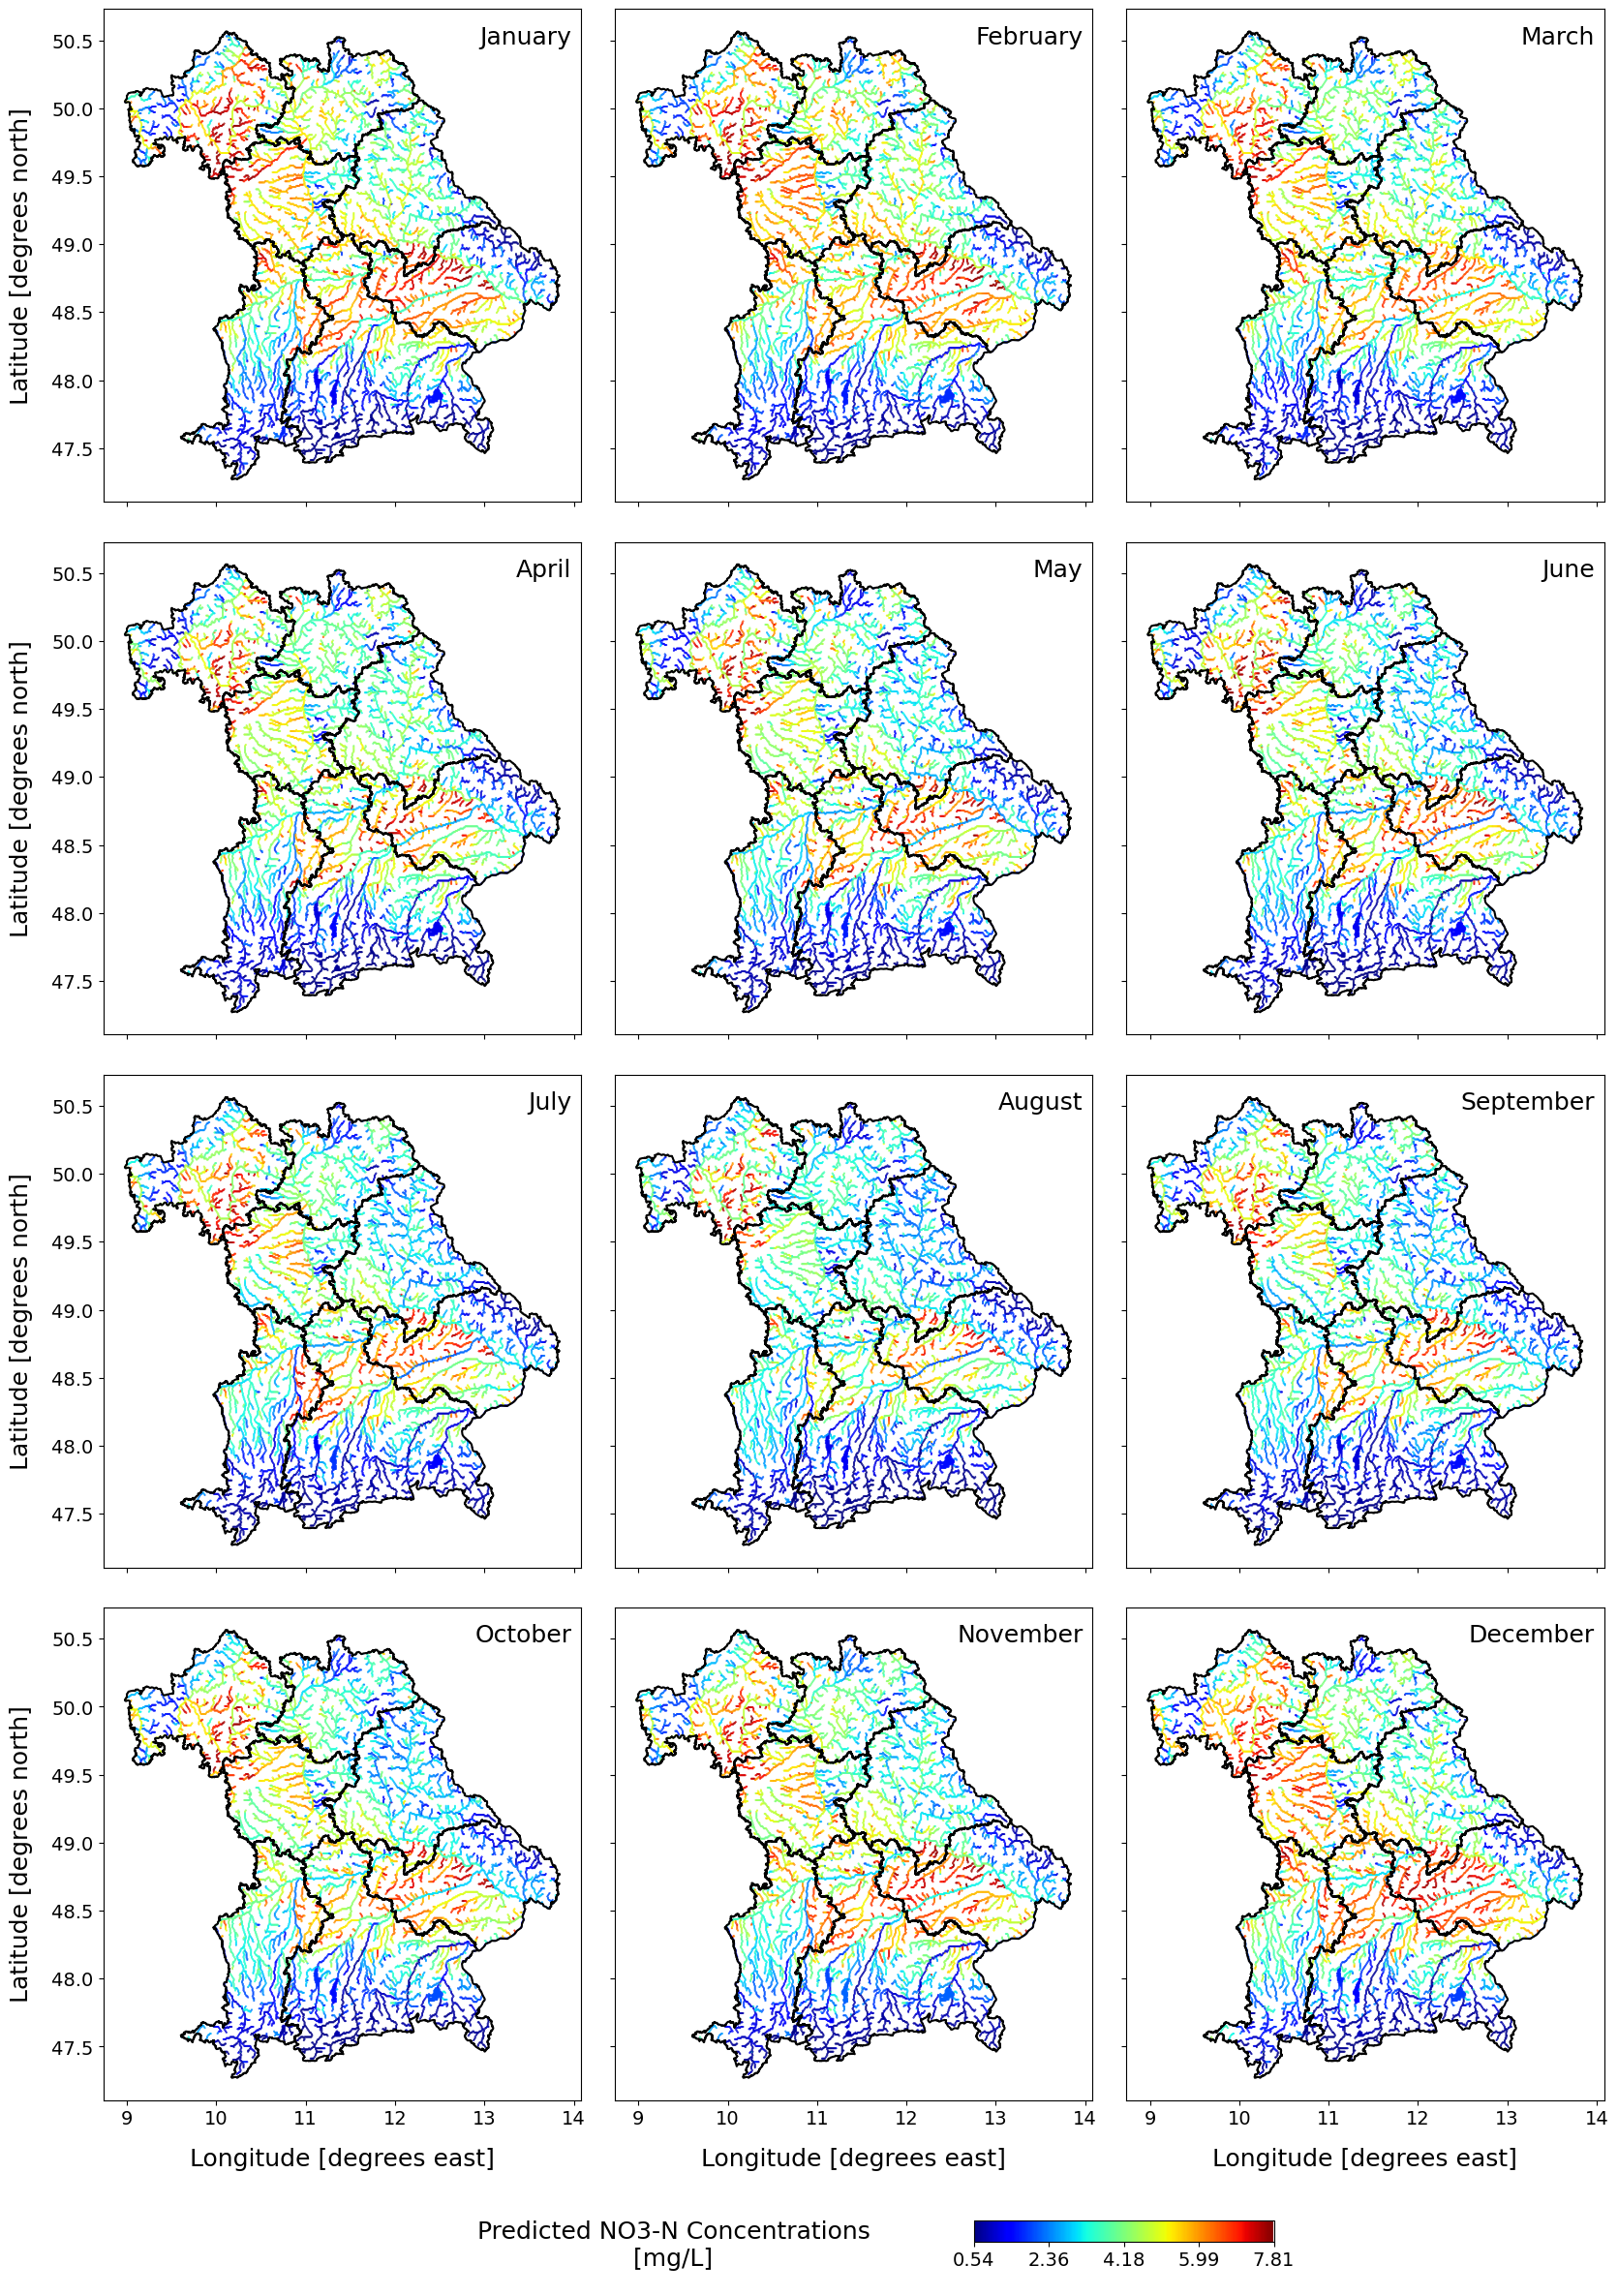

In [32]:
# plot the predicted concentrations

pred_all = []
for df in dfs_to_save.values():
    pred_all.extend(df['NO3-N [mg/l]'].tolist())
pred_all = np.array(pred_all)    

row_dict = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 4, 13: 4, 14: 4}  # storing row indices for subplot in a dictionary
col_dict = {0: 0, 1: 1, 2: 2, 3: 0, 4: 1, 5: 2, 6: 0, 7: 1, 8: 2, 9: 0, 10: 1, 11: 2, 12: 0, 13: 1, 14: 2}  # storing column indices for subplot in a dictionary
label_dict = {0: 'January', 1: 'February', 2: 'March', 3: 'April', 4: 'May', 5: 'June', 6: 'July', 7: 'August', 8: 'September', 9: 'October', 10: 'November', 11: 'December'}  # storing labels for subplot in a dictionary


norm = plt.Normalize(vmin=pred_all.min(), vmax=pred_all.max())
fig = plt.figure(figsize=(20, 30))
grid = plt.GridSpec(5, 3, wspace = 0.07,hspace = 0.01, height_ratios=[10,10,10,10,2])



for i in range(13):
    
    if i < 12:    
        df_month = dfs_to_save[months[i]]
        ax = fig.add_subplot(grid[row_dict[i], col_dict[i]])
        bavaria_districts.boundary.plot(ax=ax, color='black')
        #bavaria_polygon.plot(ax=ax, color='white', edgecolor='black')
        sc = ax.scatter(df_month.loc[:,'geometry'].x, df_month.loc[:,'geometry'].y, c=norm(df_month.loc[:,'NO3-N [mg/l]']), cmap='jet', s=0.2)
        
        ax.text(0.98, 0.93, label_dict[i], transform = ax.transAxes, size = 18,ha='right')
        
        # only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
        if i in range(9,12):
            
            ax.set_xlabel('Longitude [degrees east]', fontsize = 18, labelpad = 14)

        
        # only add y label for the first column of subplot    
        if i in range(0,10,3):
            
            ax.set_ylabel('Latitude [degrees north]', fontsize = 18, labelpad = 14)

            
        if i not in range(9,12):
            ax.set_xticklabels([])
        
        
        if i not in range(0,10,3): 
            ax.set_yticklabels([])

        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
    
    else:
        # plot the legend in the last row of subplot and combine all the columns
        cbar_ax = fig.add_subplot(grid[row_dict[i], :])
        
# manually adjust the positions of the subplots and the color bar
for ax in fig.axes[:-1]:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.02, pos.width, pos.height])      

# insert the colorbar as an axes in the last row of subplot grid. this row was reserved for legend and has no data. 
cax = cbar_ax.inset_axes([0.58, 0.42,0.2, 0.2], transform=cbar_ax.transAxes) # [left, bottom, width, height] 
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), cax=cax, orientation='horizontal')
min_cbar = round((pred_all.min()), 2)
max_cbar = round((pred_all.max()),2)
ticks = np.linspace(min_cbar,max_cbar , 5)
cbar.set_ticks(ticks) # the colorbar represents the normalized data by default so add ticks manually
cbar.set_ticklabels(np.around(np.linspace(min_cbar,max_cbar , 5), decimals = 2), fontsize=14 )
cbar_ax.text(0.38, 0.2, "Predicted NO3-N Concentrations\n [mg/L] ", fontsize=18, ha="center", transform=cbar_ax.transAxes)

# remove boundaries of the last row of subplot grid
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)


#plt.savefig('final_predictions_MM_RS_300dpi_TEST.jpg', format = 'jpg', bbox_inches = 'tight', dpi=500)
    

In [26]:
# Relative error map
rel_errors_concat = []
for month, df in dataframes.items(): 
    print('currently ', month)
    for j, row in df.iterrows():
        
        lon = row['lon']
        lat = row['lat']
        measured = row['NO3-N [mg/l]']
        prediction_df = prediction_dataframes[month]
        prediction = prediction_df.loc[(prediction_df['lon']==lon) & (prediction_df['lat']== lat), ["y_pred_og"]].values[0][0]
        print('measured: ',measured)
        print('prediction: ',prediction)
        relative_error = np.round(((abs(measured - prediction))/measured)*100,3)
        
        print('relative error', relative_error)
        print("\n")
        df.loc[j,'rel_error'] = relative_error
        rel_errors_concat.append(relative_error)

currently  jan
measured:  6.162333333333334
prediction:  4.474814125776742
relative error 27.384


measured:  4.294
prediction:  2.905199616086106
relative error 32.343


measured:  8.701
prediction:  7.241206442790857
relative error 16.777


measured:  3.4465
prediction:  3.138236610391024
relative error 8.944


measured:  3.4653333333333336
prediction:  3.5855304453999306
relative error 3.469


measured:  7.232
prediction:  5.505480982600808
relative error 23.873


measured:  6.102
prediction:  6.38221219737279
relative error 4.592


measured:  2.486
prediction:  4.3026179925577175
relative error 73.074


measured:  3.0886666666666667
prediction:  3.6230693894221955
relative error 17.302


measured:  2.067833333333333
prediction:  3.8326405468807194
relative error 85.346


measured:  0.7772
prediction:  1.2262659054218403
relative error 57.78


measured:  4.972
prediction:  5.04700571345286
relative error 1.509


measured:  0.8886666666666666
prediction:  2.187310322670363
relative e

In [25]:
dataframes['jul']

NO3-N [mg/l]  NO3-N [mg/l] BC  \
0        4.821333         2.188384   
1        2.471000         1.028438   
2        3.766667         1.714114   
3        2.734500         1.145806   
4        4.819500         2.106403   
5        6.328000         2.726419   
6        6.629333         2.821920   
7        2.881500         1.301034   
8        2.591333         1.139601   
9        1.039571         0.037623   
10       0.682400        -0.357717   
11       3.237500         1.476225   
12       1.001667        -0.005439   
13       1.779750         0.580340   
14       1.777667         0.640398   
15       4.407000         2.020808   
16       3.415111         1.575748   
17       1.508250         0.412380   
18       1.536667         0.466496   
19       0.596333        -0.474446   
20       7.420333         3.054307   
21       3.486857         1.607538   
22       4.616544         2.083653   
23       3.537000         1.506469   
24       3.860447         1.772242   
25       1.555353         0.468526   
26       0.565000        -0.515141   
27       2.697138         1.194713   
28       3.584034         1.641522   
29       0.520000        -0.575478   
30       3.785500         1.737444   
31       5.198000         2.329296   
32       4.520000         2.063109   
33       8.211333         3.301091   
34       3.150400         1.249247   
35       0.542000        -0.543303   
36       2.561333         1.136420   
37       2.702744         1.214877   
38       0.416059        -0.742259   
39       1.178270         0.151467   
40       4.444667         2.031921   
41       1.232316         0.205560   
42       0.979167        -0.024301   
43       4.670667         2.103293   
44       1.864077         0.699466   
45       1.152500         0.144944   
46       0.729268        -0.306586   
47       3.073500         1.388246   
48       2.655500         1.187692   
49       0.972000        -0.215174   
50       4.124500         1.866338   
51       1.998429         0.786795   
52       2.636667         1.178886   
53       0.881333        -0.162071   
54       4.407000         1.988155   
55       0.490000        -0.621116   
56       1.182667         0.153915   
57       1.172900        -0.006375   
58       4.407000         2.006335   
59       3.073667         1.225940   
60       4.520000         2.066382   
61       2.410667         1.053562   
62       3.621947         1.679853   
63       4.407000         2.020808   
64       3.768649         1.720178   
65       5.819500         2.552450   
66       4.143333         1.892300   
67       1.993474         0.787719   
68       3.164000         1.451925   
69       0.966000        -0.035741   
70       5.001478         2.246021   
71       0.949700        -0.059476   
72       1.785500         0.650753   
73       0.935400        -0.067334   
74       3.069000         1.371356   
75       3.465333         1.600683   
76       1.017000        -0.005816   
77       4.859000         2.198904   
78       2.787333         1.266206   
79       1.898333         0.721668   
80       2.360324         1.007700   
81       2.684878         1.192162   
82       2.147000         0.839526   
83       2.132000         0.837188   
84       4.143333         1.867947   
85       2.034000         0.591239   
86       0.538000        -0.556538   
87       0.753333        -0.280632   
88       2.380667         1.028540   
89       3.390000         1.568994   
90       6.177333         2.677747   
91       2.418250         1.056049   
92       3.540667         1.644504   
93       2.542500         1.124599   
94       1.115000         0.094030   
95       4.248800         1.951996   
96       2.486000         1.096626   
97       2.180500         0.914332   
98       1.536667         0.401666   
99       3.917333         1.792363   
100      0.514844        -0.585379   
101      7.458000         3.077887   
102      4.785550         2.140339   
103      0.660842        -0.386065   
104      4.6047

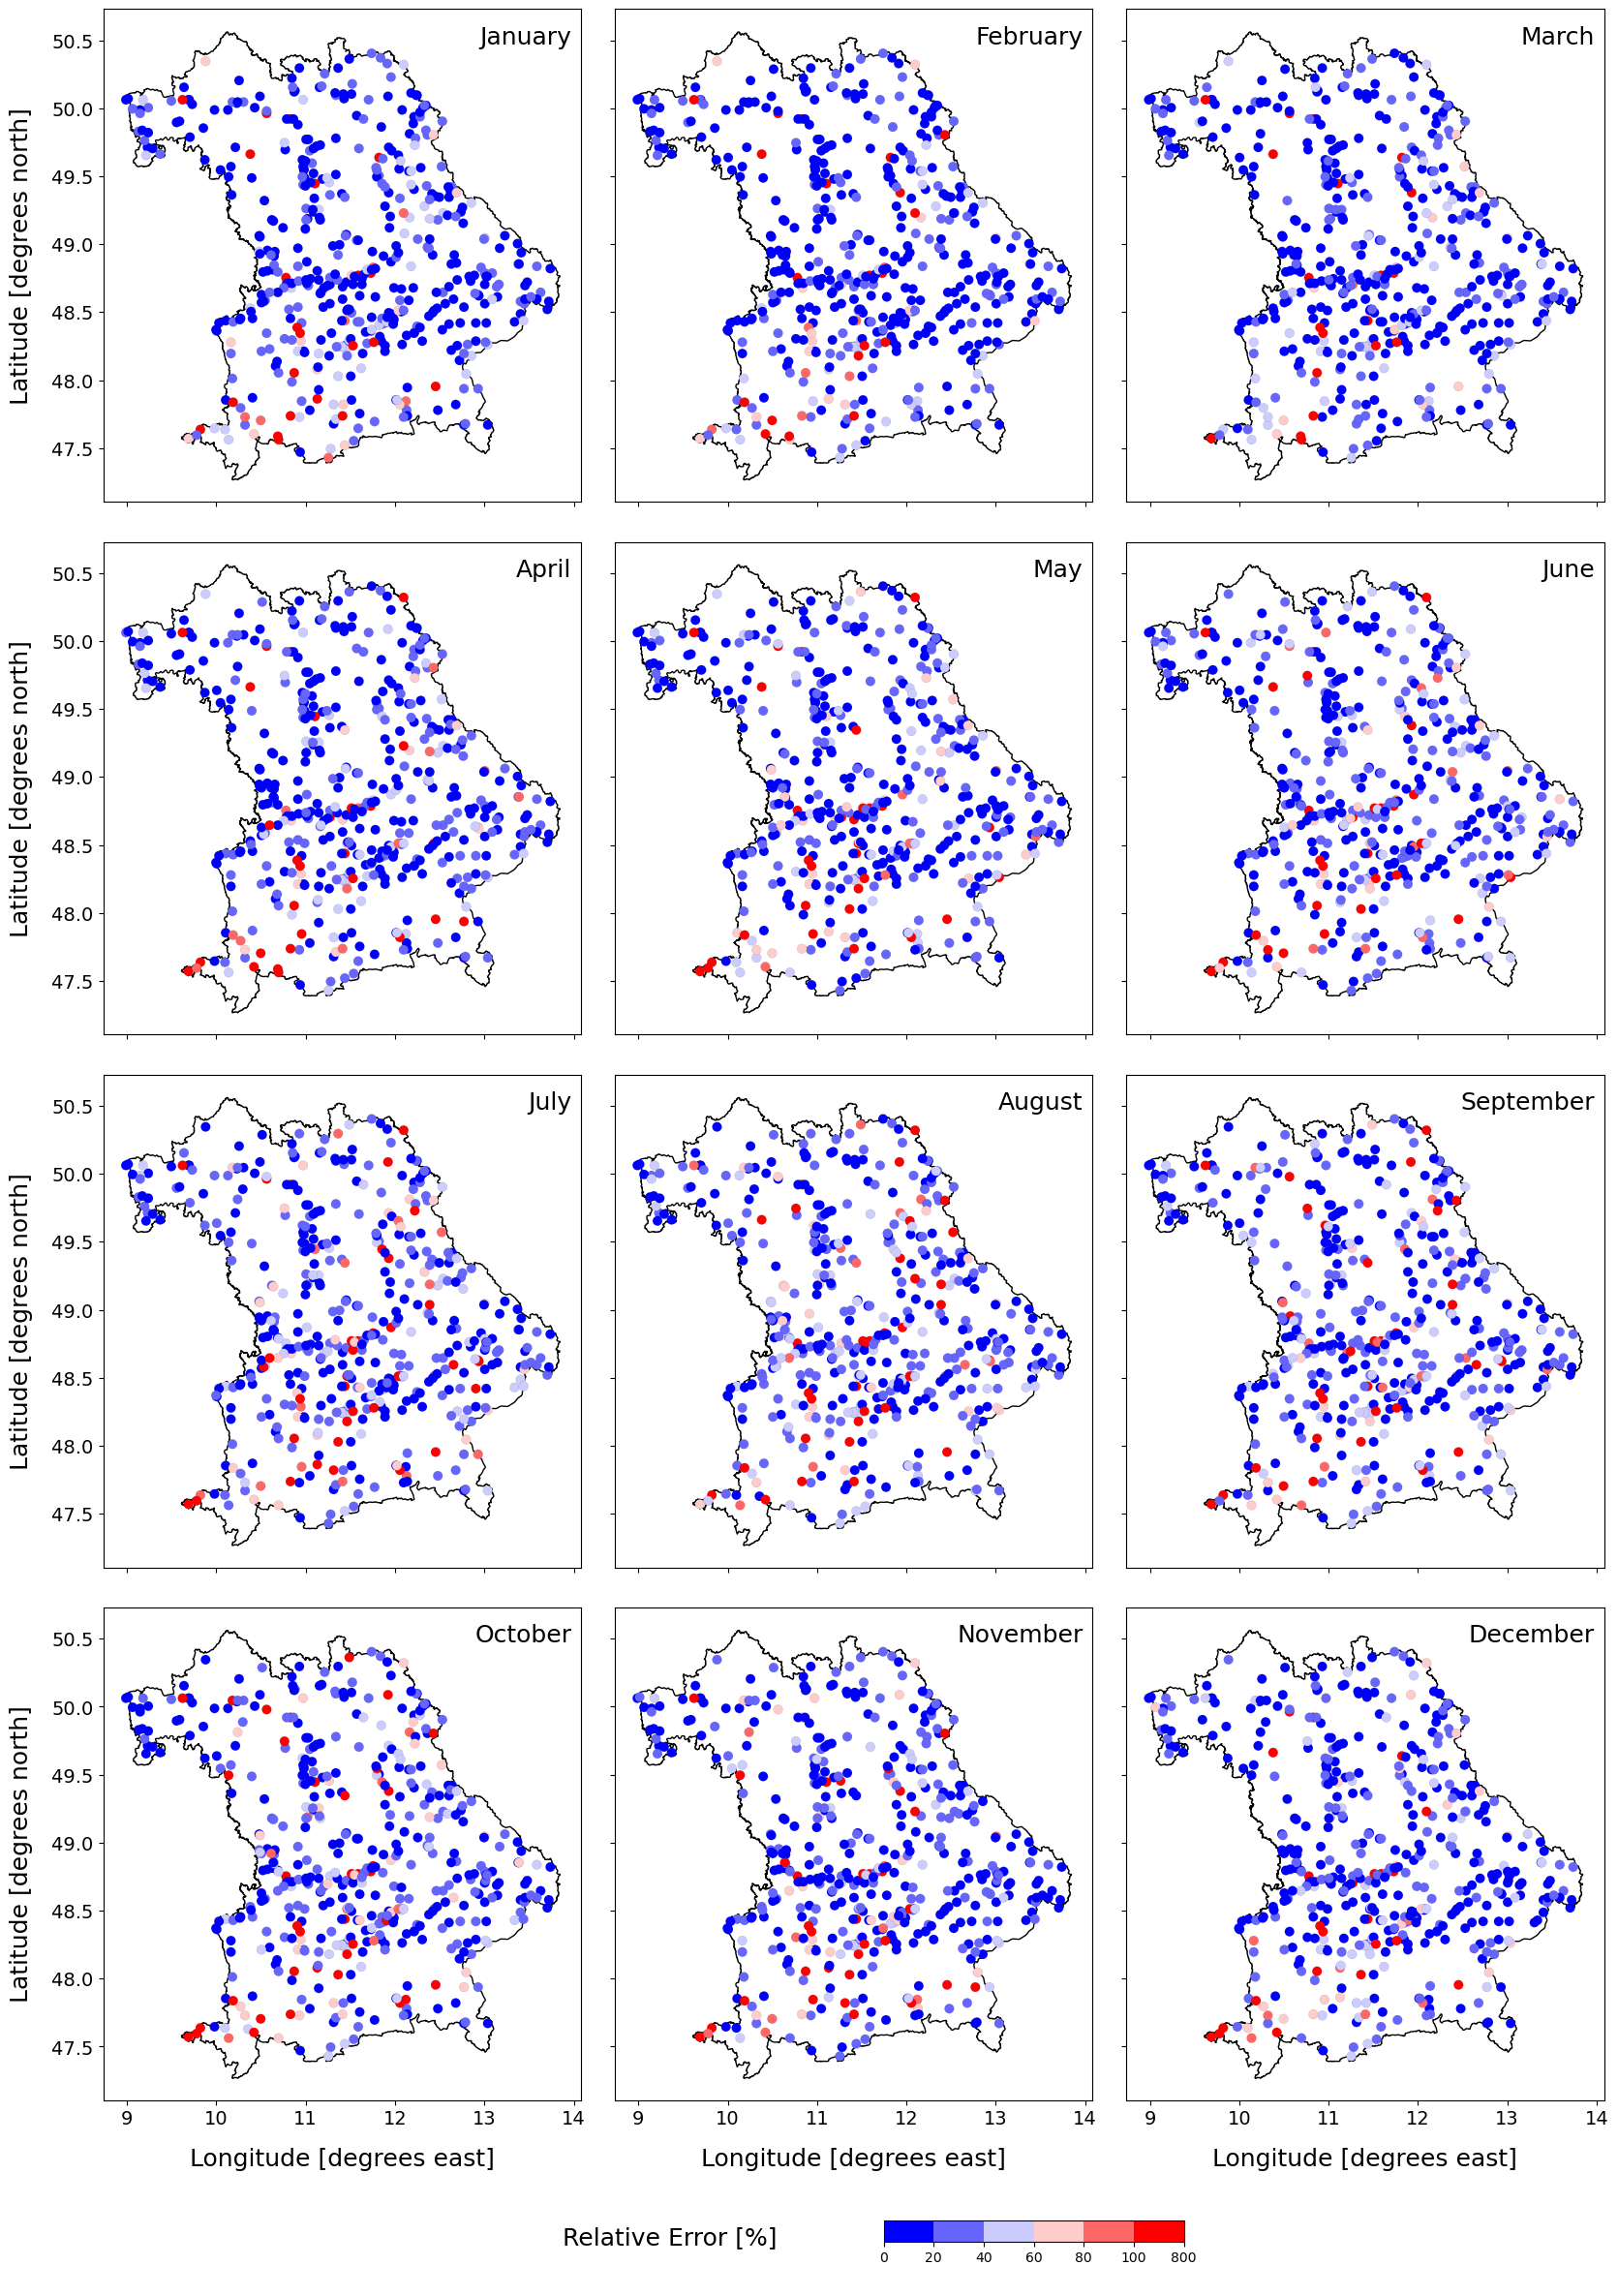

In [26]:
# relative error plot


pred_all = rel_errors_concat

row_dict = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 4, 13: 4, 14: 4}  # storing row indices for subplot in a dictionary
col_dict = {0: 0, 1: 1, 2: 2, 3: 0, 4: 1, 5: 2, 6: 0, 7: 1, 8: 2, 9: 0, 10: 1, 11: 2, 12: 0, 13: 1, 14: 2}  # storing column indices for subplot in a dictionary
label_dict = {0: 'January', 1: 'February', 2: 'March', 3: 'April', 4: 'May', 5: 'June', 6: 'July', 7: 'August', 8: 'September', 9: 'October', 10: 'November', 11: 'December'}  # storing labels for subplot in a dictionary

# Normalize for a uniform colorbar
#norm = plt.Normalize(vmin=min(pred_all), vmax=max(pred_all))
# Define the range and boundaries for the color bar
bounds = [0, 20, 40, 60, 80, 100, 800]  # Values above 200 will fall into the 800+ bin
norm = BoundaryNorm(bounds, ncolors=256, clip=True)


fig = plt.figure(figsize=(20, 30))
grid = plt.GridSpec(5, 3, wspace = 0.07,hspace = 0.01, height_ratios=[10,10,10,10,2])



for i in range(13):
    
    if i < 12:    
    

        lon_list = dataframes[months[i]].loc[:, 'lon']
        lat_list = dataframes[months[i]].loc[:, 'lat']
        error_list = dataframes[months[i]].loc[:, 'rel_error']
        
        ax = fig.add_subplot(grid[row_dict[i], col_dict[i]])
        bavaria_polygon.plot(ax=ax, color='white', edgecolor='black')
        sc = ax.scatter(lon_list, lat_list, c=norm(error_list), cmap='bwr', s=50, edgecolors='black', linewidths=0.05)
        
        ax.text(0.98, 0.93, label_dict[i], transform = ax.transAxes, size = 18,ha='right')
        
        # only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
        if i in range(9,12):
            
            ax.set_xlabel('Longitude [degrees east]', fontsize = 18, labelpad = 14)

        
        # only add y label for the first column of subplot    
        if i in range(0,10,3):
            
            ax.set_ylabel('Latitude [degrees north]', fontsize = 18, labelpad = 14)

            
        if i not in range(9,12):
            ax.set_xticklabels([])
        
        
        if i not in range(0,10,3): 
            ax.set_yticklabels([])

        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
    
    else:
        # plot the legend in the last row of subplot and combine all the columns
        cbar_ax = fig.add_subplot(grid[row_dict[i], :])
        
# manually adjust the positions of the subplots and the color bar
for ax in fig.axes[:-1]:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.02, pos.width, pos.height])      

# insert the colorbar as an axes in the last row of subplot grid. this row was reserved for legend and has no data. 
cax = cbar_ax.inset_axes([0.52, 0.42,0.2, 0.2], transform=cbar_ax.transAxes) # [left, bottom, width, height] 
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='bwr'), cax=cax, orientation='horizontal', boundaries=bounds)
min_cbar = round(min(pred_all), 2)
max_cbar = round(max(pred_all),2)
ticks = np.linspace(min_cbar,max_cbar , 5)
#cbar.set_ticks(ticks) # the colorbar represents the normalized data by default so add ticks manually
cbar.set_ticks([0, 20, 40, 60, 80, 100,800])
#cbar.set_ticklabels(np.around(np.linspace(min_cbar,max_cbar , 5), decimals = 2), fontsize=14 )
cbar.set_ticklabels(['0', '20', '40', '60', '80', '100','800'])
cbar_ax.text(0.38, 0.4, "Relative Error [%] ", fontsize=18, ha="center", transform=cbar_ax.transAxes)

# remove boundaries of the last row of subplot grid
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)


#plt.savefig('residuals_monthly_models_nss.svg', format = 'svg', bbox_inches = 'tight')
    

## Save as netCDF

In [33]:
dfs_to_save

{'jan':        NO3-N [mg/l]                   geometry
 0          1.951347  POINT (10.22917 47.29583)
 1          1.960193  POINT (10.23750 47.30417)
 2          1.940301  POINT (10.24583 47.30417)
 3          1.949116  POINT (10.25417 47.31250)
 4          1.906771  POINT (10.26250 47.31250)
 ...             ...                        ...
 16445      2.312420  POINT (10.11250 50.52917)
 16446      2.347799  POINT (10.12083 50.52917)
 16447      2.977043  POINT (10.12917 50.52917)
 16448      2.559619  POINT (10.14583 50.52917)
 16449      2.448121  POINT (10.13750 50.53750)
 
 [16450 rows x 2 columns],
 'feb':        NO3-N [mg/l]                   geometry
 0          1.169652  POINT (10.22917 47.29583)
 1          1.408515  POINT (10.23750 47.30417)
 2          1.187175  POINT (10.24583 47.30417)
 3          1.408997  POINT (10.25417 47.31250)
 4          1.122357  POINT (10.26250 47.31250)
 ...             ...                        ...
 16445      2.806954  POINT (10.11250 50.5291

In [37]:
# Enable Dask's automatic parallelization
dask.config.set(scheduler='threads')
# Load the shapefile
shapefile_path = r"z\study_project\geoBoundaries-DEU-ADM1-all\bavaria_outline.shp"
bavaria_polygon = gpd.read_file(shapefile_path)
bavaria_polygon = bavaria_polygon.to_crs('EPSG:4326')
data = xr.open_dataset(r"J:\study_project_revitalised\features\monthly_tmin_average.nc").chunk({'variable': 10, 'lat': 1000, 'lon': 1000})

In [38]:
data_rio = data.rio.write_crs("EPSG:4326")

In [41]:
# Crop the data using the region of interest, applying the shapefile's geometry
clipped_data = data_rio.rio.clip(bavaria_polygon.geometry.apply(mapping), bavaria_polygon.crs, drop=True)

In [44]:
# Assuming clipped_data is your xarray object loaded from the NetCDF file.
# Extract full grid lat and lon values
lat_full = clipped_data.lat.values
lon_full = clipped_data.lon.values

# Define time coordinate: 1 to 12 (each representing a month)
time_coords = np.arange(1, 13)

# Create a new array of shape (time, lat, lon) filled with NaN
NO3_N_array = np.full((len(time_coords), len(lat_full), len(lon_full)), np.nan)

# Define the order of months corresponding to the keys in dfs_to_save
# Adjust the list if your keys differ from these exact names.
month_keys = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
              'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Loop through each month and fill in the NO3-N values for the river grid cells
for time_idx, month in enumerate(month_keys):
    # Get the geodataframe for the current month
    gdf = dfs_to_save[month].copy()
    
    # Extract lon and lat from the geometry (assuming shapely Points)
    # This creates new columns 'lon' and 'lat' in the geodataframe.
    gdf['lon'] = gdf.geometry.x
    gdf['lat'] = gdf.geometry.y
    
    # Loop over the rows in the geodataframe
    for _, row in gdf.iterrows():
        # Extract the coordinate for this point
        lat_val = row['lat']
        lon_val = row['lon']
        
        # Find the indices in the full grid (assuming an exact match)
        lat_indices = np.where(lat_full == lat_val)[0]
        lon_indices = np.where(lon_full == lon_val)[0]
        
        # If both indices are found, assign the NO3-N value
        if lat_indices.size > 0 and lon_indices.size > 0:
            # Use the first index in case there is more than one match
            NO3_N_array[time_idx, lat_indices[0], lon_indices[0]] = row['NO3-N [mg/l]']

# Create an xarray DataArray from the NO3-N array
NO3_N_da = xr.DataArray(
    NO3_N_array,
    dims=('time', 'lat', 'lon'),
    coords={'time': time_coords, 'lat': lat_full, 'lon': lon_full},
    name='NO3-N'
)

In [57]:
NO3_N_ds = NO3_N_da.to_dataset()

In [59]:
NO3_N_ds.attrs['title'] = 'Average monthly NO3-N Concentration in Bavaria River Network'
NO3_N_ds.attrs['description'] = 'This dataset contains modeled average monthly NO3-N concentrations for river network pixels only. Land pixels have NaN.'
NO3_N_ds.attrs['authors'] = 'Karan Mahajan, Jingshui Huang'
NO3_N_ds.attrs['institution'] = 'Technical University of Munich (TUM)'
NO3_N_ds.attrs['contact'] = 'karan.mahajan@tum.de, jingshui.huang@tum.de'
NO3_N_ds.attrs['creation_date'] = pd.Timestamp.now().isoformat()

In [60]:
NO3_N_ds

<xarray.Dataset> Size: 22MB
Dimensions:  (time: 12, lat: 396, lon: 584)
Coordinates:
  * time     (time) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 3kB 47.27 47.28 47.29 47.3 ... 50.55 50.55 50.56
  * lon      (lon) float64 5kB 8.979 8.988 8.996 9.004 ... 13.82 13.83 13.84
Data variables:
    NO3-N    (time, lat, lon) float64 22MB nan nan nan nan ... nan nan nan nan
Attributes:
    title:          Average monthly NO3-N Concentration in Bavaria River Network
    description:    This dataset contains modeled average monthly NO3-N conce...
    authors:        Karan Mahajan, Jingshui Huang
    institution:    Technical University of Munich (TUM)
    contact:        karan.mahajan@tum.de, jingshui.huang@tum.de
    creation_date:  2025-04-01T20:53:54.634204

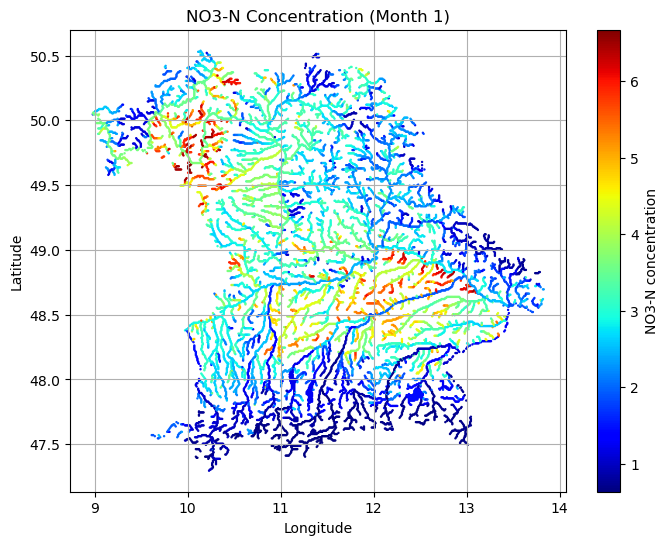

In [56]:
# Extract first month (time index 0)
da_month1 = NO3_N_da.isel(time=7)

# Get the 2D lat/lon meshgrid
lon2d, lat2d = np.meshgrid(NO3_N_da.lon.values, NO3_N_da.lat.values)

# Flatten arrays
data_flat = da_month1.values.flatten()
lon_flat = lon2d.flatten()
lat_flat = lat2d.flatten()

# Mask out NaNs
valid_mask = ~np.isnan(data_flat)
lon_valid = lon_flat[valid_mask]
lat_valid = lat_flat[valid_mask]
no3_valid = data_flat[valid_mask]

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(lon_valid, lat_valid, c=no3_valid, cmap='jet', s=0.5)
plt.colorbar(scatter, label='NO3-N concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NO3-N Concentration (Month 1)')
plt.grid(True)
plt.show()

In [62]:
NO3_N_ds.to_netcdf(r"J:\study_project_revitalised\paper_material\filtered_code\netCDF_output\predicted_conc.nc")